# k-means
### Modelo 02
- CountVectorizer
- Base B


#### Imports necessarios para funcionamento da aplicacao

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score
from nltk import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#### Leitura do arquivo de dados

In [2]:
df = pd.read_csv('../../base_b.csv')

df.head()

,nome,categoria
0,BRAHMA,BRAHMA
1,BRAHMA 550ML,BRAHMA
2,BRAHMA CERV 350ML LT,BRAHMA
3,BRAHMA CERVEJA 350ML,BRAHMA
4,BRAHMA CERVEJA 350ML LT,BRAHMA


#### Efetua o tratamento dos dados

In [3]:
le = LabelEncoder()

df.categoria = le.fit_transform(df.categoria)

df.head()

,nome,categoria
0,BRAHMA,0
1,BRAHMA 550ML,0
2,BRAHMA CERV 350ML LT,0
3,BRAHMA CERVEJA 350ML,0
4,BRAHMA CERVEJA 350ML LT,0


#### Função de tokenização

In [4]:
stemmer = RSLPStemmer()

def token(text):
    text = re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', text)
    txt = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in txt]

#### Lista de Stop Words

In [5]:
stopwords_arquivo = pd.read_csv('../../stopwords.csv')

lista_stop_words = [ token(word)[0] for word in stopwords_arquivo.stopwords.values ]

#### Separa base de treino e teste

In [6]:
X_train,X_test,y_train,y_test = train_test_split(
    df.nome,
    df.categoria,
    test_size = 0.3,
    random_state = 42
)

#### Define CountVectorizer

In [7]:
count_vectorizer = CountVectorizer(
    tokenizer=token,
    ngram_range=(1,3),
    stop_words=lista_stop_words
)

#### Cria vocabulário

In [8]:
X_train = count_vectorizer.fit_transform(X_train.values)

## Etapa de treinamento
#### Cria um classificador k-means

In [9]:
kmeans = KMeans(
    n_clusters = 15,
    random_state=24
)

#### Treina o classificador

In [10]:
kmeans.fit(X_train.toarray(), y_train)

KMeans(n_clusters=15, random_state=24)

## Etapa de Teste

#### Efetua a predição

In [11]:
Y_Pred = kmeans.predict(count_vectorizer.transform(X_test).toarray())

#### Calcula a acurácia do classificador

In [12]:
print('acuracia: {:.1f}'.format(accuracy_score(y_test, Y_Pred) * 100))
print('precisao: {:.1f}'.format(precision_score(y_test, Y_Pred, average="weighted") * 100))

acuracia: 13.2
precisao: 8.6


#### Tabela com os itens classificados errados na base de teste

In [13]:
d = []

for i in range(len(X_test)):
    au = count_vectorizer.transform([X_test.values[i]])
    pred = kmeans.predict(au.toarray())
    if (y_test.values[i] != pred[0]):
        d.append(
            [
                X_test.values[i],
                le.inverse_transform([y_test.values[i]])[0],
                le.inverse_transform(pred)[0]
            ]
        )

df_error = pd.DataFrame(data=d,columns=['Nome','Categoria Original','Pred'])
df_error

,Nome,Categoria Original,Pred
0,CERV SKOL PURO MALTE 473M,SKOL,SUCO LARANJA
1,GUARANA PET 600ML,GUARANA ANTARTICA,SUCO LARANJA INTEGRAL
2,CERVEJA SKOL 550ML,SKOL,BRAHMA
3,FANTA GUARANA LATA 350 ML,FANTA,SUCO LARANJA INTEGRAL
4,SUCO INT LARANJA 1LT,SUCO LARANJA INTEGRAL,GUARANA ANTARTICA
...,...,...,...
776,REFRIGERANTE CINI GENGIBIRRA 350 ML,CINI REFRIGERANTE,BRAHMA
777,REFRIGERANTE PEPSI TWIST 350ML,PEPSI,BRAHMA
778,SUCO DE LARANJA CAMPO LARGO 900 ML,SUCO LARANJA,GUARANA ANTARTICA
779,FANTA LATA LARANJA,FANTA,SUCO UVA


#### Gráfico

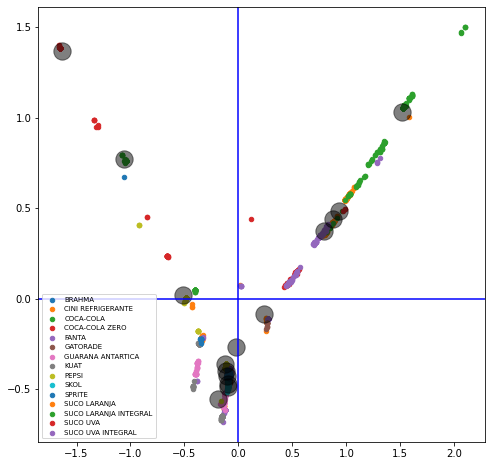

In [14]:
model = PCA(n_components=2)
transformed = model.fit_transform(X_train.todense(), y_train)
fig, ax = plt.subplots(figsize=(8,8))

for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(transformed[:,0][ix], transformed[:,1][ix], cmap='tab20b', s=20, label = le.inverse_transform([g])[0])

centers = model.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='black', alpha=0.5)

plt.legend(loc='lower left',fontsize=7)
plt.axhline(color='b')
plt.axvline(color='b')
plt.show()

#### Termos por cluster

In [15]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = count_vectorizer.get_feature_names()
for i in range(15):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ', '.join(top_ten_words)))

Cluster 0: suc, gatorad, brahm, cin, peps, kuat, zer, skol, fant, coc
Cluster 1: col, coc, coc col, sacuc, coc col sacuc, col sacuc, zer, sacuc zer, col sacuc zer, acuc
Cluster 2: suc larg, larg, suc, integr, laranj, suc larg laranj, larg laranj, laranj integr, larg laranj integr, suc larg integr
Cluster 3: col, zer, col zer, coc, coc col zer, coc col, co, col zer divers, zer divers, co col
Cluster 4: suc, integr, suc integr, vall, tint, tint integr, larg, suc vall, so, laranj
Cluster 5: beat, skol beat, skol, beat sens, skol beat sens, sens, skol beat sem, beat gin, beat sem, skol beat gin
Cluster 6: suc, laranj, suc laranj, prat, vall, natur, int, suc prat, prat laranj, suc prat laranj
Cluster 7: sprit, fresh, orig, sprit orig, lima, sprit fresh, zer, acuc, lemon, sprit zer
Cluster 8: suc, integr, laranj integr, laranj, suc laranj integr, suc laranj, vall, suc vall, prat, one
Cluster 9: cin, frambo, cin frambo, zer, frambo cin, frambo zer, cin frambo zer, laranj, cin laranj, cin zer


#### Matriz de Confusão

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1246b7250>)

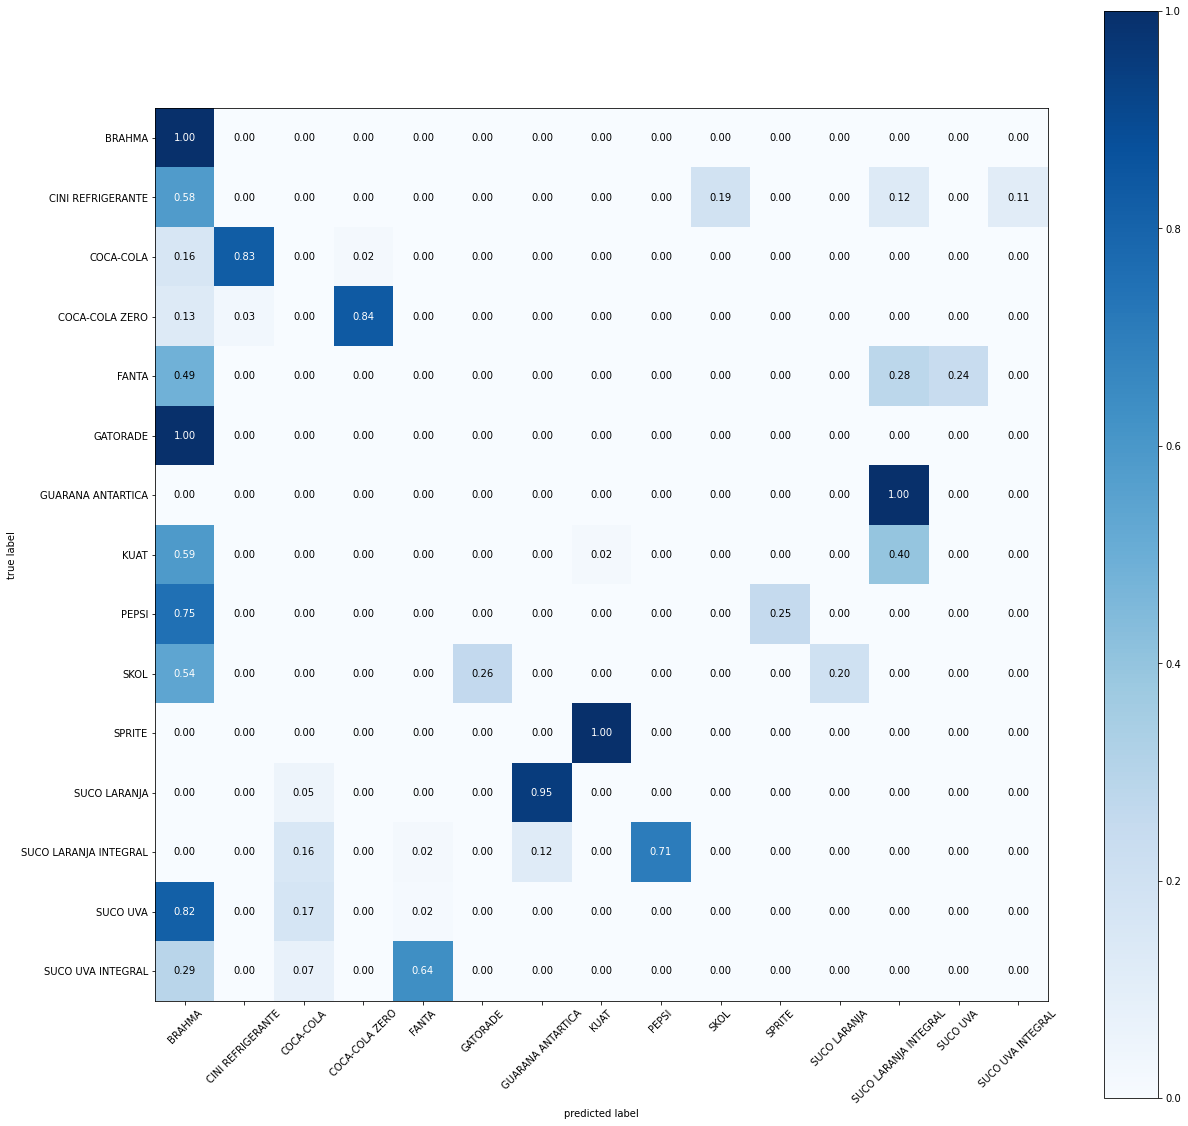

In [16]:
plot_confusion_matrix(
    conf_mat=confusion_matrix(y_test, Y_Pred),
    figsize=(20, 20),
    show_absolute=False,
    show_normed=True,
    colorbar=True,
    class_names=np.unique(le.inverse_transform(y_test))
)